In [8]:
import pandas as pd
import os
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
url = 'https://raw.githubusercontent.com/MengSui0218/CS668-2021-MS/main/clean_data.csv'
df = pd.read_csv(url)
df = df.drop(['Unnamed: 0'], axis =1 )
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
1,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
3,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,0,No Deposit,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03
4,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,0,No Deposit,240.0,0,Transient,82.0,0,1,Canceled,2015-05-06


In [3]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

1. based on EDA, cancellation from years to years keeps the same level, but it dose vary in different month. Thus, in ML process, column arrival_date_year will be dropped. 
2. column related to after check-in are supposed to be dropped, such as *assigned_room_type*, *reservation_status*, 

# Prepare training data 


In [17]:
df_ml = df.drop(['arrival_date_year','reservation_status','reservation_status_date','assigned_room_type'],axis=1)

x, y = df_ml.drop(['is_canceled'], axis= 1), df_ml['is_canceled']


In [18]:
x.columns

Index(['hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

# Organize training steps 
In this project, there are a few category atributes that can not be numeriazed by related machine learning algorithms. Thus transdering them to number is necessery for them before applying machine learning algorithms. 
When trasfering string type to number type, using sequenced number to present a series of category string is common transformantion. But issues can arise when original categories are norminal. Simply using number to reprent norminal data will mistakely assump that categories has order and different impact level on final prediciton. Thus, we used onehot encoder to transform category data. 
OneHot Encoder adds new coresponding columns to present categories, and use "0" and "1" to present observations belongs to these categories. 

In [22]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

str_transformer = Pipeline(steps= [('onehot',OneHotEncoder(handle_unknown = 'ignore'))])
str_col = ['hotel','arrival_date_month','meal','country','market_segment','distribution_channel','deposit_type','customer_type']
preprocesser = ColumnTransformer(transformers= [('Str',str_transformer, str_col)])

# Try out different algorithms 
Try out different algorithms at the same time to select out the algorithm that has the highest prediction accuracy even based on defaut parameters. It is efficient to select the best suitable machine learning algorithms.

SVM is out of my computation resource

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfolds = 10 
split = KFold(n_splits = kfolds, shuffle = True, random_state=42)


base_model = [('dt',DecisionTreeClassifier(random_state=42)),
              ('rf', RandomForestClassifier(random_state=42)),
              #('SVM',SVC(gamma='auto')),
              ('lgr', LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)),
              #('NB',GaussianNB(priors=2)),
              ('KNN',KNeighborsClassifier(n_neighbors=3))]

res = []
alg_name = []
for name, model in base_model:
  model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', model)])
  
  cv_result = cross_val_score(model_steps,
                              x,y,
                              cv = split,
                              scoring = 'accuracy')
  res.append(cv_result)
  alg_name.append(name)

  min_score = round(min(cv_result),4)
  max_score = round(max(cv_result),4)
  mean_score = round(np.mean(cv_result),4)
  std = round(np.std(cv_result),4)
  
  print(f'{name} cross validation score: {mean_score}+/-{std}, min: {min_score}, max: {max_score}')

dt cross validation score: 0.7682+/-0.0036, min: 0.7642, max: 0.777
rf cross validation score: 0.7684+/-0.0038, min: 0.7635, max: 0.7776
lgr cross validation score: 0.7345+/-0.0034, min: 0.7279, max: 0.7401
KNN cross validation score: 0.6647+/-0.004, min: 0.6569, max: 0.6698


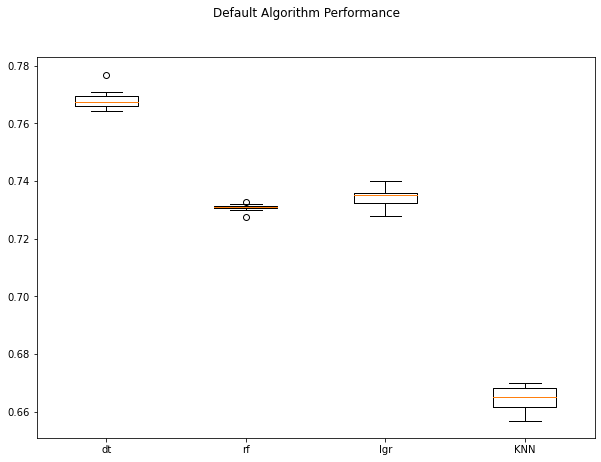

In [13]:
# plot model prediction accuracy 
fig = plt.figure(figsize = (10,7))
fig.suptitle('Default Algorithm Performance')
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(alg_name)
plt.show()

Thus, Decision Tree and Linear Regression have the top 2 accuracy rate. For next step, we fine-tuned the model by adjusting cerntain paramters to get higher prediction rate. 

# Fine Tune the model 
1. 64% data is used to training model 
2. 33% data is used to test

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=42)


tune_model = [('dt',DecisionTreeClassifier(random_state=42), 
                {'model__criterion': ("gini","entropy"), 
                'model__max_depth': range(1,15),
                'model__max_features' : ("auto","sqrt", "log2"),
                'model__splitter' : ("best", "random"),
                }),
              ('lgr', LogisticRegression(solver='newton-cg', max_iter=1000,random_state=42),
                {'model__penalty': ("l2","none")}),
              ]

opt_res = []
opt_alg_name = []
for name, model, parameter in tune_model:
    model_steps = Pipeline(steps = [('preprocesser', preprocesser),
                                  ('model', model)])
    clf = GridSearchCV(
            estimator = model_steps, 
            param_grid = parameter, 
            cv = 10,
            scoring='accuracy'
        )

    #clf.fit(x_train, y_train)
    # the whole dataset 
    clf.fit(x, y)
    opt_res.append(cv_result)
    opt_alg_name.append(name)

    print(f"Best parameters for {name}:")
    print(f'{clf.best_params_} \n')
    print(f'Grid scores on development set:')
    #means = np.mean(clf.cv_results_['mean_test_score'])
    #stds = np.std(clf.cv_results_['std_test_score'])
    print(f'the higest accuracy rate cane be reached at {clf.best_score_} \n' )

Best parameters for dt:
{'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': 'auto', 'model__splitter': 'random'} 

Grid scores on development set:
the higest accuracy rate cane be reached at 0.7139013349949341 

Best parameters for lgr:
{'model__penalty': 'none'} 

Grid scores on development set:
the higest accuracy rate cane be reached at 0.669727672972192 



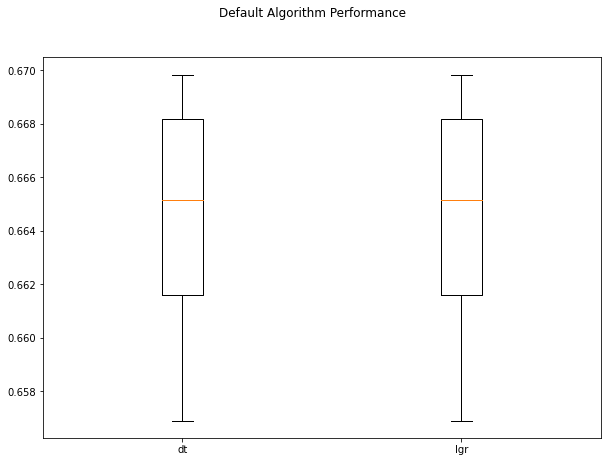

In [26]:
# plot model prediction accuracy 
fig = plt.figure(figsize = (10,7))
fig.suptitle('Default Algorithm Performance')
ax = fig.add_subplot(111)
plt.boxplot(opt_res)
ax.set_xticklabels(opt_alg_name)
plt.show()

# check out importance 

In [ ]:
# redo the best model 


In [ ]:
print(dict(zip(x.columns, clf.feature_importances_)))